<h2><a>1. Introduction</a></h2>

This tutorial tries to introduce the concept of collaborative filtering by walking through the steps involved in building a collaborative filtering system for movie ratings. For this, we use the data provided by Netflix, as part of their Netflix Prize event, which was an open competition for the best algorithm to predict user ratings for films, based on previous ratings without any other information about the users or films, i.e, without the users or films being identified except by their unique ids assigned to them as part of the contest. 

<h2><a>2. Tutorial Content</a></h2>

In this tutorial, we will cover the basic and slightly advanced approaches to building a collaborative filtering based recommender system in Python, using [NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/) and [scikit-learn](http://scikit-learn.org/stable/).

The following topics will be covered in this tutorial:
- [Dataset](#3.-Netflix-Dataset)
- [Dataset Exploration](#4.-Dataset-Exploration)
- [Collaborative Filtering](#5.-Collaborative-Filtering)
    - [Memory Based CF](#5a.-Memory-based-CF)
    - [Model Based CF](#5b.-Model-based-CF)
    - [Hybrid](#5c.-Hybrid-CF)
- [References](#6.-References)

<h2><a>3. Netflix Dataset</a></h2>

The sample of the Netflix Prize data has been split into 3 components: train, development and the test. The development and testing sets were created by sampling points from the training set, removing them, and adding them into either the development set or the testing set.

<h3><a>3a. Training Set</a></h3>

The training set is the input to the collaborative system, and consists of movie-user pairs, along with their rating. The format of the data is as follows:

<u>"MovieID", "UserID", "Rating", "RatingDate"</u><br/>
MovieID1,UserID11,rating_score_for_UserID11_to_MovieID1,the_date_of_rating
MovieID1,UserID12,rating_score_for_UserID12_to_MovieID1,the_date_of_rating

where rating_score_for_UserID*_to_MovieID* are decimal values between 1.0 and 5.0 and dates have the format YYYY-MM-DD.

<h3><a>3b. Development Set</a></h3>

The development set has the same format of the training set, which consists of movie-user pairs, along with their rating. The purpose of the development/validation set is to help with hyperparameter tuning of the several parameters involved in the model.

<h3><a>3b. Testing Set</a></h3>

The test set consists of movie-user pairs, without a rating. The format of the data is as follows:

<u>"MovieID","UserID"</u><br/>
MovieID1,UserID11<br/>
MovieID1,UserID12

The task is to predict the ratings of these pairs given the training data.

<h2><a>4. Dataset Exploration</a></h2>

We need to import the following modules for this tutorial: 
(Specific instructions as to how to install the modules/libraries have not been provided as these are among the most frequently used tools, as part of this course.) 

In [4]:
%matplotlib inline
import os
import numpy as np
import collections
from scipy.sparse import lil_matrix
from scipy.stats import pearsonr
import pandas as pd
from sklearn.preprocessing import normalize
import operator
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Now that we have all the programming environment set up for our task, let's explore the dataset before performing any of the tasks related to colloborative filtering.

In [5]:
train_file = "train.csv";
train_data = np.loadtxt(train_file, delimiter = ',', usecols = (0,1,2), dtype = np.int32)
# Since we donot need the rating date during any of our processing steps, we ignore that particular column by using the 'usecols' args.
print("Training Data:\nMovieID UserID Rating\n", train_data[:10])
movies = train_data[:, 0]
num_movies = np.max(movies)+1
users = train_data[:, 1]
num_users = np.max(users)+1
ratings = train_data[:,2]
print("Num of Movies:{0}\nNum of Users:{1}".format(num_movies, num_users))
print("Average rating value:", np.mean(ratings))

Training Data:
MovieID UserID Rating
 [[ 0  0  3]
 [ 0  1  3]
 [ 1  2  3]
 [ 1  3  4]
 [ 1  5  3]
 [ 1  6  3]
 [ 1  7  3]
 [ 1  9  3]
 [ 1 10  3]
 [ 1 11  3]]
Num of Movies:5392
Num of Users:10916
Average rating value: 3.38049054712


Let's now visualize the data and gather general information about the distribution of ratings in the dataset, number of ratings per user, number of ratings per movie, etc. and see if we can make any general inferences or gather some patterns in our dataset.

The following snippet tries to plot the histogram of movie ratings in the training data:

{3: 254913, 4: 249007, 2: 110689, 1: 52813, 5: 136619}


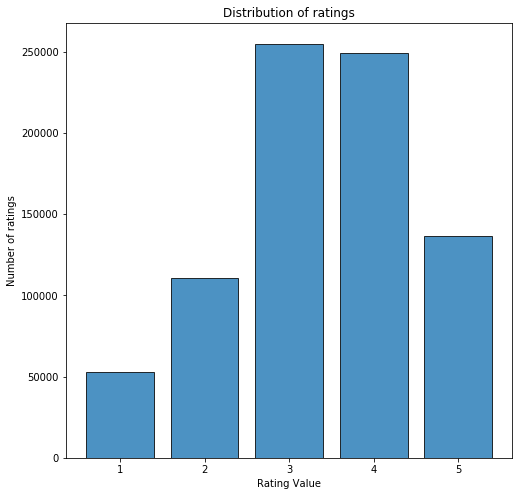

In [12]:
fig = plt.figure(figsize=(8, 8))
ratings_counter = dict(collections.Counter(ratings))
print(ratings_counter)
rating_vals = ('1', '2', '3', '4', '5')
y_pos = np.arange(len(rating_vals))
values = []
for i in range(1, 6):
    values.append(ratings_counter[i])
plt.bar(y_pos, values, align='center', alpha=0.8, ec='black')
plt.xticks(y_pos, rating_vals)
plt.ylabel('Number of ratings')
plt.xlabel('Rating Value')
plt.title("Distribution of ratings")
plt.show()

Another interesting thing to look at, is the frequency of movies by their average ratings when distributed on a 1.0 resolution(The average rating for a movie is rounded off to the nearest integer rating on a scale of 1-5 for this plot):

{3: 2823, 4: 1344, 1: 136, 2: 943, 5: 92}


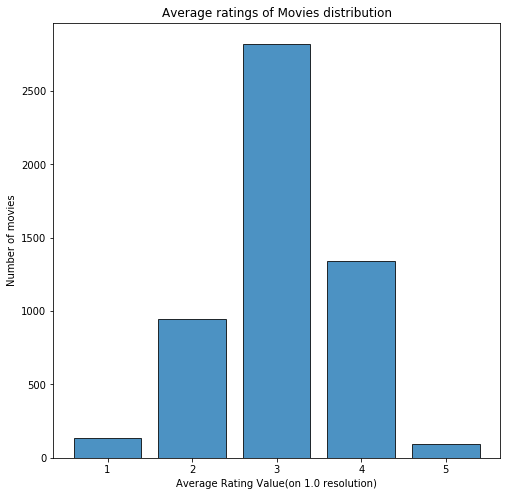

In [13]:
movie_counter=dict(collections.Counter(movies))
movie_total_dict = {}
for i in range(len(movies)):
    curr_movie = movies[i]
    curr_rating = ratings[i]
    if(curr_movie in movie_total_dict):
        movie_total_dict[curr_movie]+= curr_rating
    else:
        movie_total_dict[curr_movie]=curr_rating
for movie in movie_total_dict:
    movie_total_dict[movie] = int(round(movie_total_dict[movie]/movie_counter[movie]))
movie_average_rating = dict(collections.Counter(movie_total_dict.values()))
print(movie_average_rating)
fig = plt.figure(figsize=(8, 8))
rating_vals = ('1', '2', '3', '4', '5')
y_pos = np.arange(len(rating_vals))
values = []
for i in range(1, 6):
    values.append(movie_average_rating[i])
plt.bar(y_pos, values, align='center', alpha=0.8, ec='black')
plt.xticks(y_pos, rating_vals)
plt.ylabel('Number of movies')
plt.xlabel('Average Rating Value(on 1.0 resolution)')
plt.title("Average ratings of Movies distribution")
plt.show()

Similar to the plot above, we can also take a look at the number of users who gave a particular rating(when the average ratings given by a user are distributed on a 1.0 resolution - The average rating given by a user is rounded off to the nearest integer rating on a scale of 1-5 for this plot):

{3: 5390, 4: 4762, 2: 318, 1: 75, 5: 303}


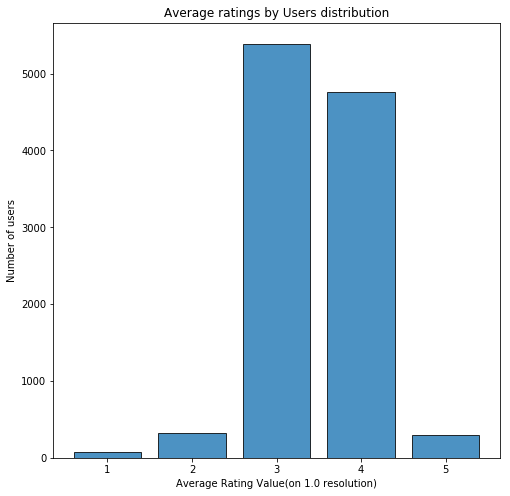

In [14]:
user_counter=dict(collections.Counter(users))
user_total_dict = {}
for i in range(len(users)):
    curr_user = users[i]
    curr_rating = ratings[i]
    if(curr_user in user_total_dict):
        user_total_dict[curr_user]+= curr_rating
    else:
        user_total_dict[curr_user]=curr_rating
for user in user_total_dict:
    user_total_dict[user] = int(round(user_total_dict[user]/user_counter[user]))
user_average_rating = dict(collections.Counter(user_total_dict.values()))
print(user_average_rating)
fig = plt.figure(figsize=(8, 8))
rating_vals = ('1', '2', '3', '4', '5')
y_pos = np.arange(len(rating_vals))
values = []
for i in range(1, 6):
    values.append(user_average_rating[i])
plt.bar(y_pos, values, align='center', alpha=0.8, ec='black')
plt.xticks(y_pos, rating_vals)
plt.ylabel('Number of users')
plt.xlabel('Average Rating Value(on 1.0 resolution)')
plt.title("Average ratings by Users distribution")
plt.show()

<h2><a>5. Collaborative Filtering</a></h2>

Collaborative Filtering(CF) is a technique used by recommender systems for making automated predictions about the interests of a particular user by collecting preferences from multiple similar users(as a way of collaborating). The underlying assumption that is made in such an approach is that if two persons X and Y share the same opinion about a particular issue, it is highly likely that they share the same opinion about a completely new issue. For example, CF approach could be used to provide recommendations to a person about movies based on the movie interests of similar users. In practice, we could imagine Amazon recommending items for online shopping to a user or Netflix recommending movies to a particular user. In this current tutorial, we formulate the CF task as trying to predict the rating that a particular user would give to a movie based on other users in the dataset and their movie ratings. CF based approaches donot require content-based description of the items, but just the recorded user interaction over items. 

<h4><a>Example:</a></h4>

Typically, the training data for CF looks like:

<img src="image.png" width="600" height="400">

-> Each row in the above table corresponds to a user and each column corresponds to an item.<br />
-> So, each row can be viewed as a user profile(over a bag of items) and each column can be viewed as an item profile(over a bag of users).<br />
-> Each cell in the table(if non-empty), corresponds to the rating given by a user to an item. The empty cells could either be due to missing data or items which did not get rated by a user(which is very likely in a real-life dataset).<br />
-> In practical datasets, the above user-item matrix would have many rows and columns(of the order of millions or billions) and be very sparse.<br />
-> The task in CF often is to predict the unrated items for each new user(the "query":q).

<h3><a>Types of CF</a></h3>

There are several CF methods to predict the ratings of a particular item based on the user-item matrix provided as data. A few of them include:

<h3><a>5a. Memory based CF</a></h3>

This approach uses the user-item rating data to compute the similarity between users or items. Once you find the top-k similar users or items, make inferences about the new unknown ratings based on these top-k user or item profiles. Since this approach needs to look at how similar a particular user or item is, to another user or item and then predict the ratings based on the ratings given by the top-k, we could use several similarity metrics to compute this. <br />

In this tutorial, we use the following two methods to compute the similarity: <u>Dot product</u> and <u>Cosine similarity.</u><br/>
<br><br>
a.) Given two user or item profiles(row or a column in the user-item matrix data), the dot-product is algebraically, the sum of the products of the corresponding entries of the two profiles. Mathematically, it is defined as : \begin{equation}
dotp(x, y) = x.y = \sum_{i=1}^n x_iy_i
\end{equation}

b.) Similarly, given two user or item profiles(row or a column in the user-item matrix data), the cosine similarity is mathematically defined as : \begin{equation}
cos(x, y) = \frac{x.y}{\|x\| \|y\|} = \frac{x}{\|x\|}.\frac{y}{\|y\|}
\end{equation}

Once you have the top-k similar profiles, the final predicted rating could just be simple mean of the top-k profile ratings for this item or a weighted mean(based on the amount of similarity) of the top-k profiles.

One important consideration while using the sparse user-item ratings matrix is: <u>How to deal with the empty cells?</u><br/>
There are several ways of addressing the problem of missing entries and this is addressed by what is known as <u>'Imputation'</u>: Filling up the missing values before computing vector similarities. The available options for imputation include:
   - <u>Option 1</u>: Fill up all the empty cells in the matrix using the global default of 3 (neutral rating).
   - <u>Option 2</u>: Keep all the empty cells unchanged, but subtract 3 from each non-empty cells.
   <img src="impute.png" width="500" height="300">
   - <u>Option 3</u>: Fill up the empty cells in each row (a user) using the mean of non-empty cells in the same row.
   - <u>Option 4</u>: Fill up the empty cells in each column (an item) using the mean of non-empty cells in the same column.

Summarizing the above memory based CF technique, we can write the following pseudo code for this approach:
<hr/>
<u>**Algorithm**: Memory based CF</u> 

<u>**Given:** User-Item rating matrix as the training set</u>

<u>**Pseudo Code:**</u>

* Store the user-rated items in the past as a training set.
* Impute the missing values in training data using any of the approaches discussed
* Find the top-k similar users/movies for each query: q(a vector with few rated items per query) using dot-product or cosine similarity.
    * $dotp(q, u_i) = q.u_i = \sum_{j=1}^m q_ju_{ij}$ 
    * $cos(q, u_i) = \frac{q.u_i}{\|q\| \|u_i\|} = \frac{q}{\|q\|}.\frac{u_i}{\|u_i\|}$ 
* Predict the movie rating for a user in each query based on the top-k similar users/movies using any of the following weighing schemes
    * Predicted user profile = $\hat{u}(q): = \sum_{u_i\in topk(q)}w(q, u_i)u_i$
        * Option 1: Mean : $w(q, u_i) = \begin{cases}
                                   \frac{1}{k} \quad if u_i \in topk(q)\\
                                   0 \quad otherwise
                                   \end{cases}$
        * Option 2: Cosine weighted : $w(q, u_i) = cos(q, u_i), \forall i$
* Evaluate the predictions based on metrics like: RMSE(Root Mean Squared Error), Accuracy %, MAE(Mean Absolute Error), etc. Tune the parameters of the model accordingly based on the performance on the dev set.

<hr/>
One important thing to note in the above algorithm is that, during the training step, there is no significant amount of processing/computation happening. All that is being done in this stage is to store the training data. The entire computation is being shifted to the prediction stage. This approach to prediction is known as <u>"Lazy Learning"</u>. The other approach is called <u>"Eager Learning"</u>, in which the system tries to construct a general, input-independent target function during training of the system. For example, "Linear Regression" is a way of eager learning as you learn the best line fitting the data(which tries to minimize the loss) during the training step itself. During the prediction step, you just substitute the values of the features in the learned function and compute the value and state it as the predicted value. On the contrary is the above "k-Nearest Neighbour" based lazy learning approach in which generalization beyond the training data is delayed until a query is actually made to the system.

There are two approaches to performing the memory-based CF: either by looking at the User-User similarity while predicting for a new query(UserID, movieID) or by looking at the Movie-Movie similarity while predicting for the query.

In [6]:
def CF(train_data):
    """ This function is responsible for forming the user_movie_matrix(imputed and non-imputed) 
        Args: 
            train_data: the training data read from the training file - movieID, userID, rating
        Returns: 
            user_movie_matrix_original : sparse matrix which contains the user-movie ratings as a matrix
            user_movie_matrix_dot_prod : sparse matrix which contains the imputed user-movie ratings as a matrix
            user_movie_matrix_cosine : sparse matrix obtained by normalizing the user profiles using the L2 norm.
        """
    user_movie_matrix = lil_matrix((num_users, num_movies)) 
    
    user_movie_matrix_original = lil_matrix((num_users, num_movies))
    rows = train_data.shape[0]
    for i in range(0, rows):
        user_movie_matrix[train_data[i][1], train_data[i][0]] = float(train_data[i][2])-3.0
        user_movie_matrix_original[train_data[i][1], train_data[i][0]] = float(train_data[i][2])
    user_movie_matrix_dot_prod = user_movie_matrix
    user_movie_matrix_cosine = normalize(user_movie_matrix, axis=1, norm='l2');
    return user_movie_matrix_original, user_movie_matrix_dot_prod, user_movie_matrix_cosine

user_movie_matrix_original, user_movie_matrix_dot_prod, user_movie_matrix_cosine = CF(train_data);
print("User-movie-matrix(non-imputed):\n", user_movie_matrix_original.todense())
print("\nUser-movie-matrix(imputed):\n", user_movie_matrix_dot_prod.todense())
print("\nUser-movie-matrix(normalized):\n", user_movie_matrix_cosine.todense())

User-movie-matrix(non-imputed):
 [[ 3.  0.  0. ...,  0.  4.  0.]
 [ 3.  0.  0. ...,  0.  0.  0.]
 [ 0.  3.  0. ...,  0.  5.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  5.  0.]]

User-movie-matrix(imputed):
 [[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  2.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  2.  0.]]

User-movie-matrix(normalized):
 [[ 0.          0.          0.         ...,  0.          0.05913124  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.14177624  0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          1.          0.        ]]


<h4><a>Memory based CF: User-User Similarity</a></h4>

In [16]:
dev_file = "dev.csv";
def compute_ratings_user_user(dev_file, user_movie_matrix, user_movie_matrix_norm, knn_k, mean):
    """ This function predicts the ratings for each element in the dev-set based on finding the top-k similar users for the user in the query(UserID, MovieID)
        Args: 
            dev_file : the held-out dev set that is used for hyperparameter tuning
            user_movie_matrix : the imputed user_movie_ratings matrix 
            user_movie_matrix_norm : the matrix which should be used to obtain the similar profiles - either dot prod or cosine matrix
            knn_k : the number of nearest neighbours to consider while predicting for a particular query
            mean : boolean(True/False) to determine whether the prediction should be a simple mean or a weighted mean of the ratings of the top-k similar user profiles
        Returns: 
            predictions : the predictions for each query in the dev file(read line by line)
            rmse : the RMSE of the predictions(since we also have the actual ratings given by the users to those movies in the dev set)
        """
    user_user_matrix = user_movie_matrix_norm.dot(user_movie_matrix_norm.T);
    knn_dict = {}
    predictions = []
    actual_ratings = []
    with open(dev_file, "r") as file:
        lines = file.read().splitlines();
        for line in lines:
            movie_id = int(line.split(",")[0])
            user_id = int(line.split(",")[1])
            actual_ratings.append(int(line.split(",")[2]))
            top_k_users = []
            similarity_values_matrix = []
            if(user_id in knn_dict):
                top_k_users = knn_dict[user_id][0]
                similarity_values_matrix = knn_dict[user_id][1]
            else:
                similarity_values_matrix = user_user_matrix.getrow(user_id).toarray()[0]
                similarity_matrix = np.argsort(-similarity_values_matrix, axis = 0)
                top_k_users = similarity_matrix[:(knn_k+1)]
                if(user_id in top_k_users):
                    top_k_users = np.delete(top_k_users, np.where(user_id==top_k_users)[0][0])
                else:
                    top_k_users = top_k_users[:-1]
                knn_dict[user_id] = (top_k_users, similarity_values_matrix)
            normalized_wts_sum = 0.0;
            curr_wts_sum = 0.0;
            rating_sum = 0.0;
            similarity_wts = 0.0
            if(mean==False):
                for i in range(len(top_k_users)):
                    rating_sum+=user_movie_matrix[top_k_users[i], movie_id]*similarity_values_matrix[top_k_users[i]];
                    similarity_wts+= similarity_values_matrix[top_k_users[i]];
                if(similarity_wts != 0):
                    rating_sum/=similarity_wts;
                else:
                    rating_sum = 0.0
                rating_sum+=3.0
                predictions.append(rating_sum)
            else:
                for i in range(len(top_k_users)):
                    rating_sum+=user_movie_matrix[top_k_users[i], movie_id];
                rating_sum/=knn_k;
                rating_sum+=3.0
                predictions.append(rating_sum)
    rmse = mean_squared_error(actual_ratings, predictions)
    return predictions, rmse
dot_prod_predictions_10_nearest_mean, dp_10_mean_rmse = compute_ratings_user_user(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_dot_prod, 10, True)
cosine_predictions_10_nearest_mean, cos_10_mean_rmse = compute_ratings_user_user(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_cosine, 10, True)
cosine_predictions_10_nearest_weighted, cos_10_wt_rmse = compute_ratings_user_user(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_cosine, 10, False)
print("User-User Similarity")
print("Dot product Similarity using 10 nearest ngbrs and mean predictions RMSE:",dp_10_mean_rmse)
print("Cosine Similarity using 10 nearest ngbrs and mean predictions RMSE:",cos_10_mean_rmse)
print("Cosine Similarity using 10 nearest ngbrs and cosine weighted predictions RMSE:",cos_10_wt_rmse)

User-User Similarity
Dot product Similarity using 10 nearest ngbrs and mean predictions RMSE: 1.00179912238
Cosine Similarity using 10 nearest ngbrs and mean predictions RMSE: 1.13364700146
Cosine Similarity using 10 nearest ngbrs and cosine weighted predictions RMSE: 1.13283493184


As you can see from the arguments passed to the above function, we chose the value of k=10(i.e predict based on the user profiles of the top-10 similar profiles to the query in the dev set). An important analysis that can be made using the above code is to find the performance as we vary the number of k, i.e the number of top-k user profiles to look at, while performing the predictions. The following code calls the above function by varying the number of nearest neighbours in each of the three scenarios and plots the RMSE values, which can help in tuning of parameters in a better way. <br>
(__Note__: The code below is computationally expensive and might take around 20 minutes to ultimately plot the desired graphs)

In [17]:
RMSE_with_k_dot_product_mean_pred = []
RMSE_with_k_cosine_mean_pred = []
RMSE_with_k_cosine_weighted_pred = []
min_ngbrs = 1
max_ngbrs = 100
for i in range(min_ngbrs, max_ngbrs):
    _, dp_mean_rmse = compute_ratings_user_user(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_dot_prod, i, True)
    RMSE_with_k_dot_product_mean_pred.append(dp_mean_rmse)
    _, cos_mean_rmse = compute_ratings_user_user(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_cosine, i, True)
    RMSE_with_k_cosine_mean_pred.append(cos_mean_rmse)
    _, cos_wt_rmse = compute_ratings_user_user(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_cosine, i, False)
    RMSE_with_k_cosine_weighted_pred.append(cos_wt_rmse)


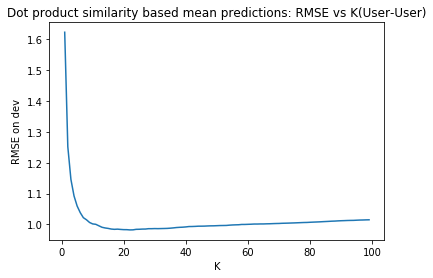

In [18]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_dot_product_mean_pred)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Dot product similarity based mean predictions: RMSE vs K(User-User)')
plt.savefig('./Dot_prod_mean-uu.png')

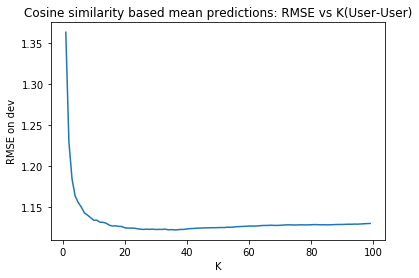

In [19]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_cosine_mean_pred)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Cosine similarity based mean predictions: RMSE vs K(User-User)')
plt.savefig('./cos_mean-uu.png')

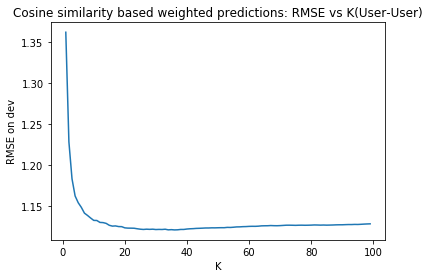

In [20]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_cosine_weighted_pred)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Cosine similarity based weighted predictions: RMSE vs K(User-User)')
plt.savefig('./cos_wt-uu.png')

<h4><a>Memory based CF: Movie-Movie Similarity</a></h4>
The difference in this approach is that you first retrieve the movies(or items) which are similar to the movieID(obtained from the query) and then predict the current movie rating based on the ratings of the top-k similar ratings. In the earlier approach you found similar "user" profiles for predicting the ratings, but here we look at similar "movie" profiles. 

As was done in the User-User similarity case, we can use either dot-product or cosine similarity to find the similar movies(to a prticular movie) and when predicting for a particular movie, we can perform simple mean of the ratings or combine them based on weights(from the cosine similarity values), which captures quantitatively, how similar a particular movie is to the current query. 

The following cells contain the corresponding code for predictions based on finding the movie-movie similarity and the similar analysis of looking at the performance of the model as the number of neighbours to consider while predicting the ratings for a userID, movieID pair is varied, is performed.

In [21]:
def computer_ratings_movie_movie(dev_file, user_movie_matrix, user_movie_matrix_norm, knn_k, mean):
    """ This function predicts the ratings for each element in the dev-set based on finding the top-k similar movies for the movie in the query(UserID, MovieID)
        Args: 
            dev_file : the held-out dev set that is used for hyperparameter tuning
            user_movie_matrix : the imputed user_movie_ratings matrix 
            user_movie_matrix_norm : the matrix which should be used to obtain the similar profiles - either dot prod or cosine matrix
            knn_k : the number of nearest neighbours to consider while predicting for a particular query
            mean : boolean(True/False) to determine whether the prediction should be a simple mean or a weighted mean of the ratings of the top-k similar movie profiles
        Returns: 
            predictions : the predictions for each query in the dev file(read line by line)
            rmse : the RMSE of the predictions(since we also have the actual ratings given by the users to those movies in the dev set)
        """
    movie_movie_matrix = user_movie_matrix_norm.T.dot(user_movie_matrix_norm);
    knn_dict = {}
    predicted_ratings = []
    actual_ratings = []
    with open(dev_file, "r") as file:
        lines = file.read().splitlines();
        for line in lines:
            movie_id = int(line.split(",")[0])
            user_id = int(line.split(",")[1])
            actual_ratings.append(int(line.split(",")[2]))
            top_k_movies = []
            similarity_values_matrix = []
            if(movie_id in knn_dict):
                top_k_movies = knn_dict[movie_id][0]
                similarity_values_matrix = knn_dict[movie_id][1]
            else:
                similarity_values_matrix = movie_movie_matrix.getrow(movie_id).toarray()[0]
                similarity_matrix = np.argsort(-similarity_values_matrix, axis = 0)
                top_k_movies = similarity_matrix[:(knn_k+1)]
                if(movie_id in top_k_movies):
                    top_k_movies = np.delete(top_k_movies, np.where(movie_id==top_k_movies)[0][0])
                else:
                    top_k_movies = top_k_movies[:-1]
                knn_dict[movie_id] = (top_k_movies, similarity_values_matrix)
            normalized_wts_sum = 0.0;
            curr_wts_sum = 0.0;
            rating_sum = 0.0;
            similarity_wts = 0.0
            if(mean==False):
                for i in range(len(top_k_movies)):
                    rating_sum+=user_movie_matrix[user_id, top_k_movies[i]]*similarity_values_matrix[top_k_movies[i]];
                    similarity_wts+= similarity_values_matrix[top_k_movies[i]];
                if(similarity_wts != 0):
                    rating_sum/=similarity_wts;
                else:
                    rating_sum = 0.0
                rating_sum+=3.0
                predicted_ratings.append(rating_sum)
            else:
                for i in range(len(top_k_movies)):
                    rating_sum+=user_movie_matrix[user_id, top_k_movies[i]];
                rating_sum/=knn_k;
                rating_sum+=3.0
                predicted_ratings.append(rating_sum)
    rmse = mean_squared_error(actual_ratings, predicted_ratings)
    return predicted_ratings, rmse
dot_prod_predictions_10_nearest_mean, dp_10_mean_rmse = computer_ratings_movie_movie(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_dot_prod, 10, True)
cosine_predictions_10_nearest_mean, cos_10_mean_rmse = computer_ratings_movie_movie(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_cosine, 10, True)
cosine_predictions_10_nearest_weighted, cos_10_wt_rmse = computer_ratings_movie_movie(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_cosine, 10, False)
print("Movie-Movie Similarity")
print("Dot product Similarity using 10 nearest ngbrs and mean predictions RMSE:",dp_10_mean_rmse)
print("Cosine Similarity using 10 nearest ngbrs and mean predictions RMSE:",cos_10_mean_rmse)
print("Cosine Similarity using 10 nearest ngbrs and cosine weighted predictions RMSE:",cos_10_wt_rmse)

Movie-Movie Similarity
Dot product Similarity using 10 nearest ngbrs and mean predictions RMSE: 1.04268283764
Cosine Similarity using 10 nearest ngbrs and mean predictions RMSE: 1.04601413944
Cosine Similarity using 10 nearest ngbrs and cosine weighted predictions RMSE: 1.04403972841


In [22]:
RMSE_with_k_dot_product_mean_pred_m = []
RMSE_with_k_cosine_mean_pred_m = []
RMSE_with_k_cosine_weighted_pred_m = []
for i in range(min_ngbrs, max_ngbrs):
    _, dp_mean_rmse = computer_ratings_movie_movie(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_dot_prod, i, True)
    RMSE_with_k_dot_product_mean_pred_m.append(dp_mean_rmse)
    _, cos_mean_rmse = computer_ratings_movie_movie(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_cosine, i, True)
    RMSE_with_k_cosine_mean_pred_m.append(cos_mean_rmse)
    _, cos_wt_rmse = computer_ratings_movie_movie(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_cosine, i, False)
    RMSE_with_k_cosine_weighted_pred_m.append(cos_wt_rmse)
    

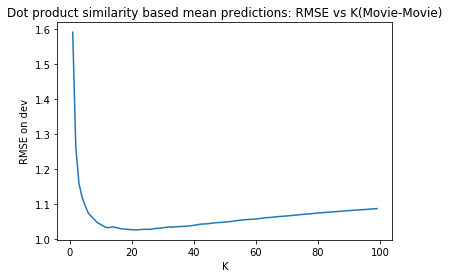

In [23]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_dot_product_mean_pred_m)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Dot product similarity based mean predictions: RMSE vs K(Movie-Movie)')
plt.savefig('./Dot_prod_mean-mm.png')

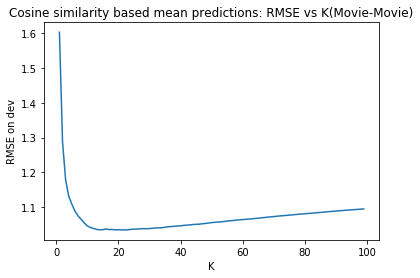

In [24]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_cosine_mean_pred_m)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Cosine similarity based mean predictions: RMSE vs K(Movie-Movie)')
plt.savefig('./cos_mean-mm.png')

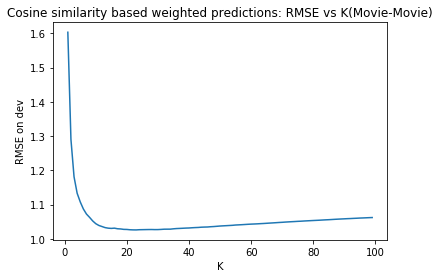

In [25]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_cosine_weighted_pred_m)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Cosine similarity based weighted predictions: RMSE vs K(Movie-Movie)')
plt.savefig('./cos_wt-mm.png')

<h4><a> Dealing with Systematic Biases in Collaborative Filtering</a></h4>

- If the system consistently favors some users over other users (not regarding the queries), we consider it a user-bias.
- If the system consistently favors some items over other items (not regarding the queries), we consider it an item-bias.

An example of user bias when trying to predict movie ratings is as follows:
- User X is grouchy and rates items with an average of 2 stars
- However, User Y is cheery and rates things with an average of 4 stars.

Clearly 3 stars from User X is very different than 3 stars from User Y. If we keep track of the average movie rating for each user (the user bias), and just try to predict the difference from that average, the recommender system works much better.

Similarly, suppose:
- Movie A gets an average rating (over all users) of 1 star.
- Movie B gets an average rating of 5 stars.

Then a 3 star rating is very different for Movie A than for Movie B. If we keep track of the average user rating for each movie (the item bias), and just try to predict the difference from that average, the recommender system also works much better.

One approach to removing/reducing the user or item bias is <u>"Standardization"</u> of user or item profiles. This involves:
1. Setting the means to zero for all the users(or items).
2. And normalizing the values in each user(or item) profile using its own variance. 

As can be inferred from the above approaches to removing biases, the method of standardization could be done either to the user profiles or the item profiles(or to both profiles). In this tutorial, the bias is reduced by standardizing the movie profiles. However, it can also be extended similarly to user profiles. 

The code snippet below standardizes a matrix, and returns it as the output.

In [8]:
def get_standard(user_movie_matrix):
    """ This function standardizes the rows of a matrix by computing the mean and standard deviation
        Args: 
            user_movie_matrix: the non-imputed user-item ratings matrix
        Returns: 
            result_matrix: the resultant matrix obtained after standardizing the rows of the given user-item matrix
        """
    rows = user_movie_matrix.shape[0]
    cols = user_movie_matrix.shape[1]
    result_matrix = np.zeros((rows, cols))
    for i in range(rows):
        curr_row = user_movie_matrix.getrow(i).toarray()[0]
        std_val = np.std(curr_row)
        if(std_val!=0):
            result_matrix[i] = (curr_row - np.mean(curr_row))/(std_val)
    return result_matrix
user_movie_matrix_standard = get_standard(user_movie_matrix_original.T)
user_movie_matrix_standard_norm = normalize(user_movie_matrix_standard, axis=1, norm='l2')
print("Original user-movie-matrix:\n", user_movie_matrix_original.T.todense())
print("\nStandardized user-movie-matrix:\n", user_movie_matrix_standard)

Original user-movie-matrix:
 [[ 3.  3.  0. ...,  0.  0.  0.]
 [ 0.  0.  3. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 4.  0.  5. ...,  0.  0.  5.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Standardized user-movie-matrix:
 [[  7.38715101e+01   7.38715101e+01  -1.35370185e-02 ...,  -1.35370185e-02
   -1.35370185e-02  -1.35370185e-02]
 [ -3.85923346e-02  -3.85923346e-02   2.52378432e+01 ...,  -3.85923346e-02
   -3.85923346e-02  -3.85923346e-02]
 [ -2.12414668e-02  -2.12414668e-02  -2.12414668e-02 ...,  -2.12414668e-02
   -2.12414668e-02  -2.12414668e-02]
 ..., 
 [ -3.56263659e-02  -3.56263659e-02  -3.56263659e-02 ...,  -3.56263659e-02
   -3.56263659e-02  -3.56263659e-02]
 [  1.85169956e+00  -5.09581057e-01   2.44201972e+00 ...,  -5.09581057e-01
   -5.09581057e-01   2.44201972e+00]
 [ -2.76594146e-02  -2.76594146e-02  -2.76594146e-02 ...,  -2.76594146e-02
   -2.76594146e-02  -2.76594146e-02]]


Once we compute the standardized matrix(which is now free of item biases), we can use the similar approach as discussed above to compute the ratings of a query based on the top-k similar item profiles. The dot product similarlity values(used when computing the weighted average over the top similar profiles) that we now obtain are same as the <u>"Pearson Correlation Coefficient"</u> between the two profiles. 

A mathematical explnation for this is as follows:

Consider two item profiles $X = (x_1, x_2, x_3, ...., x_n)$ and $Y = (y_1, y_2, y_3, ...., y_n)$

- Sample Means :- $ \bar{x} = \frac{1}{n}\sum_{i=1}^n x_i; \bar{y} = \frac{1}{n}\sum_{i=1}^n y_i $

- Sample Standard Deviations :- $\sigma_x = \sqrt{\frac{1}{n-1}\sum_{j=1}^n (x_j - \bar{x})^2}; \sigma_y = \sqrt{\frac{1}{n-1}\sum_{j=1}^n (y_j - \bar{y})^2}$

- Sample Covariance :- $\sigma_{xy} = \frac{1}{n-1}\sum_{j=1}^n (x_j - \bar{x})(y_j - \bar{y})$

- Sample Pearson Correlation Coefficent(PCC) :- $r_{xy} = \frac{\sigma_{xy}}{\sigma_x \sigma_y}$

$ \rightarrow r_{xy} = \frac{\sigma_{xy}}{\sigma_x \sigma_y} = \frac{\frac{1}{n-1}\sum_{j=1}^n (x_j - \bar{x})(y_j - \bar{y})}{\sqrt{\frac{1}{n-1}\sum_{j=1}^n (x_j - \bar{x})^2} \sigma_y = \sqrt{\frac{1}{n-1}\sum_{j=1}^n (y_j - \bar{y})^2}} = \sum_{j=1}^n\frac{x_j-\bar{x}}{\sqrt{\sum_{j=1}^n (x_j - \bar{x})^2}}\frac{y_j-\bar{y}}{\sqrt{\sum_{j=1}^n (y_j - \bar{y})^2}} = Z_x.Z_y = dotp(Z_x, Z_y),$ where $Z_x$ and $Z_y$ are standardized $X$ and $Y$ movie profiles

A brief description of the algorithm for removing movie-bias is as follows:
1. The way in which the movie bias is removed from the movie ratings given to the movies by different users is by taking into account the mean movie rating and standardizing the movie ratings given to a movie so that all the movies have a mean rating of 0 and variance of 1(which is also referred to as standardization, for which we need to subtract the mean value from each of the data points and then divide each value with the standard deviation of these points).
<br><br>
2. Once we have the standardized movie matrix (where each movie has mean = 0, std dev = 1), we find the similarity values of each movie with the other movies using these standardized values and evaluating the Pearson Correlation Coefficient(PCC) value between two movies. Once we compute the PCC values, we sort them in decreasing order of magnitude and then the top k values are treated as the top k nearest neighbors of a particular movie(since PCC value captures the amount of correlation or similarity between the ratings given to a movie and hence higher PCC value between two movies signifies higher similarity between the ratings given to both the movies).
<br><br>
3. Once we have the top k nearest neighbors of a movie obtained by calculating the PCC value of the standardized vectors, we compute the rating for this new movie by performing a weighted average over the neighboring movies by using the PCC values as the weights(The intuition behind this is that: if a movie is more similar to our new movie for which we want to compute the rating for, more similar will the rating be and hence it should carry a higher weight while computing the weighted average. Since PCC value here denotes the amount of similarity between two movies, this value could be used as the weight while combining two movies).
<br><br>
4. Removing the user bias by standardizing the movie ratings provided by a particular user to all of the movies so that his mean rating is zero and with a standard deviation(or variance) = 1 also is a technique to improve the performance of the algorithm compared to the simple straight forward approaches performed earlier(where we found the k nearest neighbors of a particular user or a movie based on the dot product or cosine based similarity, without removing any biases inherent in the system). This approach is very much similar to the standardization that was done over the movies.<br/>
The following code performs the predictions on the standardized item(in our case, movie) profiles:

In [27]:
def compute_pcc_val(x, y):
    """ This function computes the pearson correlation coefficient value, given the two vectors as input
        Args: 
            x, y: two vectors whose pcc value is to be computed
        Returns: 
            r: pcc value of vectors x and y
        """
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    r_num = np.sum((x-x_mean)*(y-y_mean))
    r_den = np.sqrt(np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))
    r = r_num/r_den
    return r

def compute_ratings_pcc(dev_file, user_movie_matrix, user_movie_matrix_standard, knn_k, mean):
    """ This function predicts the ratings for each element in the dev-set based on finding the top-k similar movies for the movie in the query(UserID, MovieID)
        Args: 
            dev_file : the held-out dev set that is used for hyperparameter tuning
            user_movie_matrix : the imputed user_movie_ratings matrix 
            user_movie_matrix_standard : the standardized matrix which should be used to obtain the similar profiles 
            knn_k : the number of nearest neighbours to consider while predicting for a particular query
            mean : boolean(True/False) to determine whether the prediction should be a simple mean or a weighted mean of the ratings of the top-k similar movie profiles
        Returns: 
            predictions : the predictions for each query in the dev file(read line by line)
            rmse : the RMSE of the predictions(since we also have the actual ratings given by the users to those movies in the dev set)
        """
    user_user_matrix = user_movie_matrix_standard.dot(user_movie_matrix_standard.T)
    knn_dict = {}
    predictions = []
    actual_ratings = []
    with open(dev_file, "r") as file:
        lines = file.read().splitlines();
        for line in lines:
            movie_id = int(line.split(",")[0])
            user_id = int(line.split(",")[1])
            actual_ratings.append(int(line.split(",")[2]))
            top_k_movies = []
            similarity_values_matrix = []
            if(movie_id in knn_dict):
                top_k_movies = knn_dict[movie_id]
            else:
                similarity_values_matrix = user_user_matrix[movie_id]
                similarity_matrix = np.argsort(-similarity_values_matrix, axis = 0)
                top_k_movies = similarity_matrix[:(knn_k+1)]
                if(movie_id in top_k_movies):
                    top_k_movies = np.delete(top_k_movies, np.where(movie_id==top_k_movies)[0][0])
                else:
                    top_k_movies = top_k_movies[:-1]
                knn_dict[movie_id] = top_k_movies
            rating_sum = 0.0;
            similarity_wts = 0.0
            if(mean==False):
                for i in range(len(top_k_movies)):
                    movie_row = user_movie_matrix_standard[movie_id]
                    ngbr_row = user_movie_matrix_standard[top_k_movies[i]]
                    std_movie = np.std(movie_row);
                    std_ngbr = np.std(ngbr_row);
                    if(not(std_movie==0 or std_ngbr==0)):
                        pcc_value = compute_pcc_val(movie_row, ngbr_row)
                        rating_sum+=user_movie_matrix[user_id, top_k_movies[i]]*pcc_value;
                        similarity_wts+= pcc_value;
                if(similarity_wts != 0):
                    rating_sum/=similarity_wts;
                else:
                    rating_sum = 0.0
                rating_sum+=3.0
                predictions.append(rating_sum)
            else:
                for i in range(len(top_k_movies)):
                    rating_sum+=user_movie_matrix[user_id, top_k_movies[i]];
                rating_sum/=knn_k;
                rating_sum+=3.0
                predictions.append(rating_sum)
    rmse = mean_squared_error(actual_ratings, predictions)          
    return predictions, rmse
dot_prod_predictions_10_nearest_mean, dp_10_mean_rmse = compute_ratings_pcc(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_standard, 10, True)
cosine_predictions_10_nearest_mean, cos_10_mean_rmse = compute_ratings_pcc(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_standard_norm, 10, True)
cosine_predictions_10_nearest_weighted, cos_10_wt_rmse = compute_ratings_pcc(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_standard_norm, 10, False)
print("Removing Movie Rating Bias")
print("Dot product Similarity using 10 nearest ngbrs and mean predictions RMSE:",dp_10_mean_rmse)
print("Cosine Similarity using 10 nearest ngbrs and mean predictions RMSE:",cos_10_mean_rmse)
print("Cosine Similarity using 10 nearest ngbrs and cosine weighted predictions RMSE:",cos_10_wt_rmse)

Removing Movie Rating Bias
Dot product Similarity using 10 nearest ngbrs and mean predictions RMSE: 1.07614700146
Cosine Similarity using 10 nearest ngbrs and mean predictions RMSE: 1.0761908825
Cosine Similarity using 10 nearest ngbrs and cosine weighted predictions RMSE: 1.07244833285


And a similar analysis done by varying the number of neighbours, we obtain:

In [28]:
RMSE_with_k_dot_product_mean_pred_std = []
RMSE_with_k_cosine_mean_pred_std = []
RMSE_with_k_cosine_weighted_pred_std = []
for i in range(min_ngbrs, max_ngbrs):
#     print(i)
    _, dp_mean_rmse = compute_ratings_pcc(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_standard, i, True)
    RMSE_with_k_dot_product_mean_pred_std.append(dp_mean_rmse)
    _, cos_mean_rmse = compute_ratings_pcc(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_standard_norm, i, True)
    RMSE_with_k_cosine_mean_pred_std.append(cos_mean_rmse)
    _, cos_wt_rmse = compute_ratings_pcc(dev_file, user_movie_matrix_dot_prod, user_movie_matrix_standard_norm, i, False)
    RMSE_with_k_cosine_weighted_pred_std.append(cos_wt_rmse)

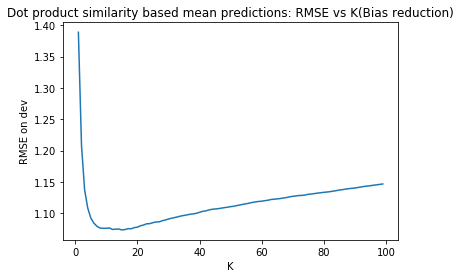

In [29]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_dot_product_mean_pred_std)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Dot product similarity based mean predictions: RMSE vs K(Bias reduction)')
plt.savefig('./Dot_prod_mean-std.png')

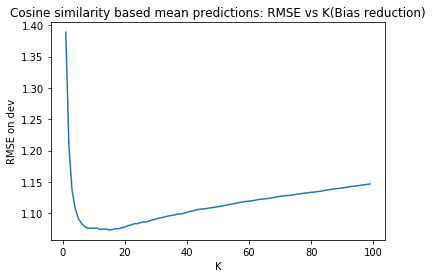

In [30]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_cosine_mean_pred_std)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Cosine similarity based mean predictions: RMSE vs K(Bias reduction)')
plt.savefig('./cos_mean-std.png')

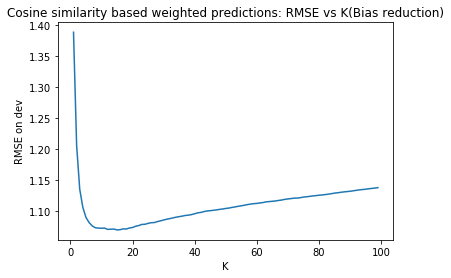

In [31]:
plt.plot(list(range(min_ngbrs, max_ngbrs)), RMSE_with_k_cosine_weighted_pred_std)
plt.ylabel('RMSE on dev')
plt.xlabel('K')
plt.title('Cosine similarity based weighted predictions: RMSE vs K(Bias reduction)')
plt.savefig('./cos_wt-std.png')

<h4><a> Analysis of Experimental Results:</a></h4>
1. From the plots in "Memory based CF: User-User/Movie-Movie" and "Standardized CF", we find that in almost all of the cases(irrespective of whether the dot-product or cosine similarity of the profiles is used to determine the similar profiles and whether the final predictions are as a result of mean or weighing schemes), as you increase the number of top-k profiles to consider, the RMSE error doesnot continuously decrease i.e as we increase the value of k beyond a certain count, the predictions are less relevant (or in other words, increasing the value of k, is leading to an overall increase in RMSE values in a majority of the cases). This could be attributed to the fact that including more and more neighbors by increasing the value of k leads to incorporating the ratings of users/movies which are not-so-closely related to the current movie and hence could lead to much worse performance. It only makes sense to use the ratings of users/movies which are very closely related to the current user/movie and compute the average value of the rating as the final result. This could be attained by putting a lower threshold on the similarity values and stating only those users/movies as relevant (or treat them as neighbors) when the similarity values (in terms or dot product or cosine similarity or PCC) is higher than the threshold.
<br><br>
2. In addition to the above experiments, the following tables also summarize the results obtained in each of the cases:
<img src="results.png" width="500" height="300">
From the above table, we find that both the dot product based similarity metric and cosine similarity based approach give roughly the same performance (< 5% difference). This could be attributed to the fact that cosine is just a normalized version of the dot product based similarity approach and hence the extra normalization component introduced did not influence the prediction results much (whose contribution is seen while finding the nearest neighbors).
<br><br>
3. From the values of RMSE obtained in Memory-based CF: user-User Similarity and Memory-based CF: Movie-Movie Similarity, we find that the performance (in terms of the RMSE values) is roughly the same (a difference of < 5% is often treated as not too different in literature) in both user-user similarity and movie-movie similarity based prediction methods. This shows that for this particular dataset(dev.csv), using either of the two approaches gives almost similar results and hence either of the two approaches could be used interchangeably. However, this directly cannot be applied to any new scenario. That would completely depend on the rating values in the new dataset.

<h4><a> Software Considerations: </a></h4>
The following were a few of the optimizations and pre-processing steps to make the implementation more efficient:
1. The formation of the user-movie rating matrix which involves the expensive I/O operation was done only once. All the subsequent operations on this matrix was done in-memory without reading the csv files(either train.csv, dev.csv or test.csv) again from disk. This saves a lot of time owing to in-memory operations being faster than disk-based operations.
<br><br>
2. Similarly, all the expensive operations of matrix multiplications (like $A*transpose(A)$ or $transpose(A)*A$ during the user-user similarity and movie-movie similarity computations) were done just once and stored to avoid recomputing again and again when required.
<br><br>
3. To ensure correctness of the code, wherever required, additional sanitary checks were put to avoid 0/0 division runtime errors (especially while standardizing matrixes, where each row of the matrix has to be divided by the standard deviation of the row).

<h4><a> Strengths and Weaknesses of the Design: </a></h4>
<h5><a> Strengths: </a></h5>
1. Re-computation of the same values, I/O based operations and redundancy in the code was minimized as much as possible. Use of dictionaries to retrieve values in O(1) time and direct matrix element indexing ensure that the lookup operations are much faster and time is not spent on doing tasks which can be done much faster just by a change of the data structure being used.

<h5><a> Weaknesses: </a></h5>
1. The time taken when the number of nearest neighbors to search for (i.e k in k-Nearest Neighbors) is 500 is significantly higher, i.e the time taken for the computation scales accordingly with the value of k. I think there is a scope for improvement here. Currently, the code performs a form of lazy computation approach – Only computing the neighbors for those in the test.csv or dev.csv file directly at run-time. I feel that there is some kind of optimization that could be done in this regard by computing the neighbors of a user/movie beforehand, but this would definitely come at the expense of some extra space. There are techniques which perform an eager approach to finding the k-Nearest Neighbors by using some special data structures, but again this leads to higher storage requirement in terms of memory consumed by the application.
<br><br>
2. Also, the computation time in case of cosine similarity was slightly higher than that in the dot-product case. This would have been completely acceptable if the performance of the cosine similarity based technique (while finding the nearest neighbors) was much much higher than the dot product. But the performance when using cosine similarity is sometimes worse or maybe atmost as good as that of the dot product (in terms of the RMSE).

<h3><a>5b. Model based CF</a></h3>

In the model based CF approaches, you use different data mining and machine learning algorithms to predict the user's ratings of the unrated items. A few of the model based CF algortithms include:
1. Bayesian Networks
2. Clustering Models
3. Latent Semantic Models
4. Markov Decision Process based Models

Since the user-item rating data is often sparse(as was also the situation in our case), "Dimentionality Reduction" is an important technique to improve the robustness and accuracy of the memory-based CF approaches. These methods(known as latent factor models) compress the sparse user-item matrix to a low-dimentional representation in terms of the latent factors. These methods are better capable to handle the sparsity of the user-item matrices better than the memory based methods, because in these cases, instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space. Also, computing the similarity between the users or items in these resulting lower dimentional matrices is much easier.<br/>
<br><br>
(__Note__: The current HW-4 talks about these Model based approaches to Collaborative Filtering, which scale proportionally to the number of non-zero observations in the user-item matrix, by performing dimensionality reduction. To avoid serious overlap between the content covered in class and this tutorial, this approach to CF has been dealt with at a superficial level, by just providing high-level insights).

<h3><a>5c. Hybrid CF</a></h3>

Majority of the current-day recommender systems, for example, the Google news recommender system are a hybrid of the memory based and model based approaches. These hybrid methods overcome the limitations of the native CF approaches, while at the same time, also improve prediction performance. They overcome the regular CF problems such as sparsity(in the user-item matrix) and the loss of information at an increased complexity and expensive implementation details.

<h2><a>6. References</a></h2>
1. [Stanford InfoLab - Recommender Systems](http://infolab.stanford.edu/~ullman/mmds/ch9.pdf)
2. [Collaborative Filtering Tutorial by Prof. William W. Cohen, CMU](https://www.cs.cmu.edu/~wcohen/collab-filtering-tutorial.ppt)
3. [A Survey of Collaborative Filtering Techniques - Xiaoyuan Su and Taghi M. Khoshgoftaar](https://www.hindawi.com/journals/aai/2009/421425/)
4. [Probabilistic Matrix Factorization - Ruslan Salakhutdinov and Andriy Mnih](https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)
5. [Recommender Systems - Carleton College](http://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/itembased.html)
6. [Model-Based Collaborative Filtering(Springer):Chapter-3 - Charu C. Aggarwal](https://link.springer.com/chapter/10.1007/978-3-319-29659-3_3)
7. [Various Implementations of Collaborative Filtering](https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0)
8. [Recommender: An Analysis of Collaborative Filtering Techniques](http://cs229.stanford.edu/proj2014/Christopher%20Aberger,%20Recommender.pdf)
9. [Recommender Systems - Prem Melville and Vikas Sindhwani(IBM Research)](http://vikas.sindhwani.org/recommender.pdf)